In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import struct
from matplotlib import pyplot


# for evaluation metrics
from sklearn.metrics import accuracy_score, f1_score


# set random seed
np.random.seed(0)
random.seed(0)

The MNIST database contains the dataset for this problem. Develop an image recognition algorithm using logistic regression based on gradient descent that can correctly classify handwritten images as 4 or not 4

## Load dataset
MNIST data can be downloaded from  http://yann.lecun.com/exdb/mnist/.

The training set contains 60000 images
The shape of the image is (28, 28)
The label of the image is 3


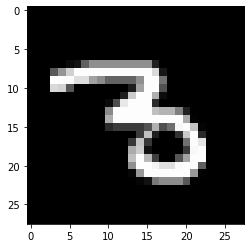

In [10]:
# load MNIST
path = '../MNIST/'   # the training set is stored in this directory

# Train data
fname_train_images = os.path.join(path, 'train-images-idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels-idx1-ubyte')  # the training set label file path
    
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    train_labels = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    train_images = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols)
    
print('The training set contains', len(train_images), 'images')  # print the how many images contained in the training set
print('The shape of the image is', train_images[0].shape)  # print the shape of the image


imgNumber = 30  # choose which image you want to display
print('The label of the image is', train_labels[imgNumber])  # print the label of the image displayed

pyplot.imshow(train_images[imgNumber], cmap='gray')  # plot the image in "gray" colormap
pyplot.show()

In [11]:
# load test set

fname_test_images = os.path.join(path, 't10k-images-idx3-ubyte')  # the training set image file path
fname_test_labels = os.path.join(path, 't10k-labels-idx1-ubyte 2')  # the training set label file path
    
# open the label file and load it to the "train_labels"
with open(fname_test_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    test_y = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_test_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    test_X = np.fromfile(fimg, dtype=np.uint8).reshape(len(test_y), rows, cols)
    
print('The training set contains', len(test_X), 'images')  # print the how many images contained in the training set
print('The shape of the image is', test_X[0].shape)  # print the shape of the image

The training set contains 10000 images
The shape of the image is (28, 28)


## Preprocessing

Flatten. Typically, pictures are reshaped to column vectors. The images in the dataset are of size (28,28)
 and should be reshaped to column vectors of size (28x28,1).

In [12]:
train_X = np.reshape(train_images, (train_images.shape[0], -1))
train_X = train_X.T
train_X.shape

(784, 60000)

In [13]:
# set y as boolean: 4 or not 4
train_y = train_labels == 4
train_y.shape

(60000,)

In [14]:
# preprocess test set
test_X = np.reshape(test_X, (test_X.shape[0], -1))
test_X = test_X.T
test_X.shape

(784, 10000)

In [15]:
test_y = test_y == 4

For scaling of picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [16]:
train_X = train_X / 255
test_X = test_X / 255

The training data set contains 60,000 examples. Create smaller training datasets for development and validation. Investigate the impact of the training data size.

In [17]:
# # shuffle the samples to select randomly

# c = list(zip(train_X, train_labels))
# random.shuffle(c)
# train_X, train_y = zip(*c)

num_s = int(train_X.shape[1] * 0.8)
train_Xs = train_X[:,:num_s]
train_ys = train_y[:num_s]
val_Xs = train_X[:,num_s:] 

train_Xs.shape

(784, 48000)

## Learning

    • Use vectorized implementation.
    • Plot the learning curve (cost function vs. number of iterations).
    • Investigate the impact of the learning rate.

forward prop: 
$$ z^{[1]} = W^{[1]} X + b^{[1]} \\ 
a^{[1]} = g^{[1]}(z^{[1]}) \\
z^{[2]} = W^{[2]} a^{[1]} + b^{[2]} \\ 
A^{[2]} = sigma(z^{[2]}) = \frac{1}{1 + e^{-(W^{[2]} a^{[1]} + b^{[2]})}} $$
 where $g(\cdot)$ is non-linear activation function such as Relu( ) or tanh( ).
 
Loss function:
$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{[2](i)})+(1-y^{(i)})\log(1-a^{[2](i)})$$


Back Prop for second layer:

$$ dz^{[2]} = A^{[2]} - Y \\
dW^{[2]} = \frac{1}{m} dz^{[2]} A^{[1]T}\\
db^{[2]} = \frac{1}{m} sum(dz^{[2]}) \\ \\
da^{[1]} = W^{[2]T} dz^{[2]} 
$$

Back Prop for first layer:

$$ dz^{[1]} = da^{[1]}* g^{[1]'}(z^{[1]}) = W^{[2]T} dz^{[2]}* g^{[1]'}(z^{[1]}) \\
dW^{[1]} = \frac{1}{m} dz^{[1]} A^{[0]T} \\
db^{[1]} = \frac{1}{m} sum(dz^{[1]}) \\
$$

where $dw$ is short-hand note for $\frac{\partial J}{\partial w} $. $*$ is pointwise manipulator.

In [191]:
# define layers    
class linear_layer(object):
    def __init__(self, in_dim, out_dim, step_size = 0.1):
        self.in_dim = in_dim
        self.out_dim = out_dim
        ## random initiate parameters, sample from normal disrtibution
        self.W = np.random.randn(self.out_dim, self.in_dim)
        self.b = np.random.randn(self.out_dim, 1)
        self.step = step_size
        
    def forward_prop(self, X):
        self.m = X.shape[1] # number of samples 
        return np.dot(self.W, X) + self.b
    
    def backward_prop(self, dz, X):   
        self.dW = np.dot(dz, X.T) / self.m 
        self.db = np.sum(dz) / self.m 
        
    def update(self):
        self.W -= self.step * self.dW
        self.b -= self.step * self.db

class logistic_regression_head(object):
    '''
        output layer of this binary classification problem.
        take the last hidden layer as input and output a single prediction value.
    '''
    def __init__(self, in_dim, step_size):
        ## random initiate parameters, sample from normal disrtibution
        self.step = step_size
        self.w = np.random.randn(1, in_dim)
        self.b = np.random.randn()
        
    def forward_prop(self, X):
        self.m = X.shape[1] # number of samples 
        self.z = np.dot(self.w, X) + self.b
        self.A = sigmoid(self.z)  # shape(1, m)
        return self.A
        
    def backward_prop(self, dz, X):
        ## gradient of weights
        self.dw = np.dot(dz, X.T) / self.m
        self.db = np.sum(dz) / self.m 
        ## gradient of input
        dx = np.dot(self.w.T, dz)
        return dx
        
    def update(self):
        self.w -= self.step * self.dw
        self.b -= self.step * self.db
        

## define functions
def sigmoid(z):
    return 1/(1+ np.exp(-z))

def cross_entropy_cost(A, y):
    '''
    A: prediction; 
    y: true value
    '''      
    m = len(y) # number of samples
    return -(np.dot(np.log(A), y.T) + np.dot(np.log(1 - A), (1 - y.T)))/m

def relu(z):
    return np.maximum(z, 0)

def grad_relu(z):
    '''
    gradient of relu given input z 
    a = relu(z)
    z: input
    '''
#     dz = np.array(da, copy = True)
    dz = np.ones_like(z)
    dz[z <= 0] = 0
    return dz
   
def grad_tanh(a):
    '''
    gradient of tanh given (input z or) gradient of output a
    a = tanh(z)
    '''
    dz = 1 - np.square(a)
    return dz

In [204]:
# define model
class one_layer_network(object):
    def __init__(self, X_train, y_train, hidden_features, activation = 'reLu', step_size = 0.1, max_iter = 1000,tol = 1e-2, random_seed = 0, verbal = True):
        self.verbal = verbal
        self.seed = random_seed
        np.random.seed(self.seed)
        self.step = step_size
        self.activation = activation
        self.tol = tol
        self.max_iter = max_iter
        self.X = X_train
        self.y = y_train
        self.n0 = X_train.shape[0] # input feature size
        self.m = X_train.shape[1] # number of samples
        self.n1 = hidden_features # hidden feature size
        
        # layers
        self.hidden_layer = linear_layer(self.n0, self.n1, self.step)
        self.output_layer = logistic_regression_head(self.n1, self.step)

    ### training functions #####
    def forward_prop(self, X, eval = False):
        if not eval:
            # in training mode, store intermediate variables for back prop
            self.z1 = self.hidden_layer.forward_prop(X)
            if self.activation == 'tanh':
                self.a1 = np.tanh(self.z1)
            else:
                #default relu
                self.a1 = relu(self.z1)
            self.a2 = self.output_layer.forward_prop(self.a1)
            return self.a2 
        else:
            # in evaluatation mode, do not store variables 
            out = self.hidden_layer.forward_prop(X)
            if activation == 'tanh':
                out = np.tanh(out)
            else:
                out = relu(out)
            out = output_layer.forward_prop(out)
            return out
    
    def backward_prop(self):
        dz2 = self.a2 - self.y
        da1 = self.output_layer.backward_prop(dz2, self.a1)
        if self.activation == 'tanh':
            dz1 = np.multiply(da1, grad_tanh(self.a1))
        else:
            #default relu
            dz1 = np.multiply(da1, grad_relu(self.z1))
        self.hidden_layer.backward_prop(dz1, self.X)
    
    def update(self):
        self.output_layer.update()
        self.hidden_layer.update()
                       
    def fit(self):
        self.costs = np.zeros(self.max_iter) # record costs
        self.costs[:] = np.nan
        for i in range(self.max_iter):
            A = self.forward_prop(self.X)
            self.costs[i] = cross_entropy_cost(A, self.y)
            self.backward_prop()
            self.update()
            
            if i % 100 == 0 and self.verbal:
                print("Cost after iteration %i : %f" %(i, self.costs[i]))
                
            if self.costs[i] < self.tol:
                print("Cost less than %e after iteration %i : %f" %(self.tol, i, self.costs[i]))
                break
                
    def plot_curve(self):
        plt.plot(self.costs)
        plt.ylabel('Cost')
        plt.xlabel('Iterations')
        plt.title('learning rate: ' + str(self.step))
        plt.show()
        
    ### testing function ###
    def predict(self, X_test):
        # if sigmoid value >= 0.5, possitive
        A = self.forward_prop(X_test, eval = False)
        return A >= 0.5
    
    def evaluate(self, test_X, test_y):
        # training score
        train_y_pred = self.predict(self.X).flatten()
        train_acc = accuracy_score(self.y, train_y_pred)
        train_f1 = f1_score(self.y, train_y_pred)
        print("Training accuracy: %.3f   F1 score: %.3f" %(train_acc, train_f1))
        # testing score
        test_y_pred = self.predict(test_X).flatten()
        test_acc = accuracy_score(test_y_pred, test_y)
        test_f1 = f1_score(test_y_pred, test_y)
        print("Testing accuracy: %.3f    F1 score: %.3f" %(test_acc, test_f1))     

In [211]:
step = 0.5
NN = one_layer_network(train_Xs, train_ys,hidden_features = 5, activation= 'tanh', step_size = step, max_iter = 1000, verbal = True)
NN.fit()

Cost after iteration 0 : 0.999878
Cost after iteration 100 : 0.290508
Cost after iteration 200 : 0.239569
Cost after iteration 300 : 0.198977
Cost after iteration 400 : 0.175113
Cost after iteration 500 : 0.157434
Cost after iteration 600 : 0.143612
Cost after iteration 700 : 0.133009
Cost after iteration 800 : 0.125156
Cost after iteration 900 : 0.119184


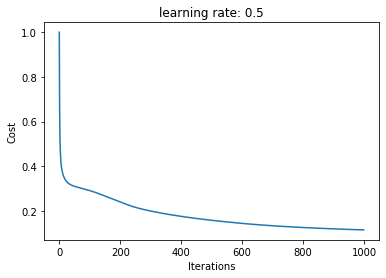

In [212]:
NN.plot_curve()

## Evaluation

    • Compute the training and the test error.
    • Try test examples.

In [213]:
NN.evaluate(test_X, test_y)

Training accuracy: 0.959   F1 score: 0.763
Testing accuracy: 0.958    F1 score: 0.766


The result shows that using 80% training sample, one hidden layer using tanh activation without regularization can achieve adequate accuracy and F1 score.

## Infulence of size of traing data

In [215]:
import time
for portion in [0.3, 0.6, 1]:
    # use just portion of data
    num_s = int(train_X.shape[1] * portion)
    train_Xs = train_X[:,:num_s]
    train_ys = train_y[:num_s]
    NN = one_layer_network(train_Xs, train_ys,hidden_features = 5, activation= 'relu', step_size = step, max_iter = 1000, verbal = False)
    # time the training process
    tic = time.clock()
    NN.fit()
    fitT = time.clock() - tic
    print("Using %.2f of training data, %d samples in toal, training took %.2f seconds" %(portion, num_s, fitT))
    # evaluate
    NN.evaluate(test_X, test_y)
    print('---------------')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


Using 0.30 of training data, 18000 samples in toal, training took 31.00 seconds
Training accuracy: 0.965   F1 score: 0.811
Testing accuracy: 0.963    F1 score: 0.798
---------------
Using 0.60 of training data, 36000 samples in toal, training took 91.52 seconds
Training accuracy: 0.964   F1 score: 0.805
Testing accuracy: 0.963    F1 score: 0.800
---------------
Using 1.00 of training data, 60000 samples in toal, training took 172.86 seconds
Training accuracy: 0.964   F1 score: 0.806
Testing accuracy: 0.962    F1 score: 0.797
---------------


We can see that a small portion of the total training data (30%) can already achieve good results with significantly less time. Meanwhile, using less data samples, the training F1 score is higher, but the testing F1 score is lower. This shows that overfitting might be happening with less data samples, leading to less generalization abilities.

## Influence of learning rate

In [239]:
# use 50% of training data
num_s = int(train_X.shape[1] * 0.5)
train_Xs = train_X[:,:num_s]
train_ys = train_y[:num_s]
Tcosts = []
for step in [5, 0.5, 0.05]:
    NN = one_layer_network(train_Xs, train_ys,hidden_features = 10, activation= 'relu', step_size = step, max_iter = 1000, verbal = False)
    print("step size: %.2f" %(step))
    NN.fit()
    NN.evaluate(test_X, test_y)
    # record the cost curve
    Tcosts.append(NN.costs)
    print('---------------')

step size: 5.00


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


Training accuracy: 0.973   F1 score: 0.873
Testing accuracy: 0.972    F1 score: 0.866
---------------
step size: 0.50
Training accuracy: 0.969   F1 score: 0.826
Testing accuracy: 0.967    F1 score: 0.815
---------------
step size: 0.05
Training accuracy: 0.904   F1 score: 0.192
Testing accuracy: 0.900    F1 score: 0.153
---------------


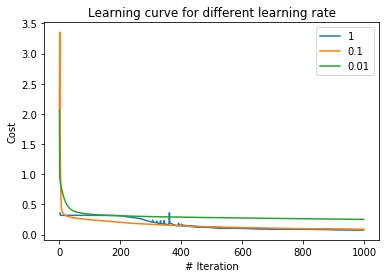

In [240]:
for cost in Tcosts:
    plt.plot(cost)
plt.xlabel('# Iteration')
plt.ylabel('Cost')
plt.legend(("1", "0.1", "0.01"))
plt.title("Learning curve for different learning rate" )
plt.show()

We can see from the result that choosing learning rate is crucial to get good results. in this case using step size too small it could not converge to optimal solution in time. And using step size too large the learning curve is not continuous, suffering from overshoot during training.

## Number of hidden units

In [225]:
for hidden_dim in [5, 10, 50]:
    # use just portion of data
    num_s = int(train_X.shape[1] * 0.6)
    train_Xs = train_X[:,:num_s]
    train_ys = train_y[:num_s]
    NN = one_layer_network(train_Xs, train_ys,hidden_features = hidden_dim, activation= 'relu', step_size = 0.5, max_iter = 1000, verbal = False)
    # time the training process
    tic = time.clock()
    NN.fit()
    fitT = time.clock() - tic
    print("Using %d hidden units, training took %.2f seconds" %(hidden_dim, fitT))
    # evaluate
    NN.evaluate(test_X, test_y)
    print('---------------')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


Using 5 hidden units, training took 94.17 seconds
Training accuracy: 0.964   F1 score: 0.805
Testing accuracy: 0.963    F1 score: 0.800
---------------
Using 10 hidden units, training took 106.80 seconds
Training accuracy: 0.968   F1 score: 0.823
Testing accuracy: 0.966    F1 score: 0.812
---------------
Using 50 hidden units, training took 312.11 seconds
Training accuracy: 0.981   F1 score: 0.901
Testing accuracy: 0.977    F1 score: 0.881
---------------


We can see that using more features will result in longer time, but the increase is sublinear with respect to number of hidden units. This shows the efficiency of vectorized implementations. Also, more hidden units results in much better performance. Generally, with more hidden units, the model is more expressive, but is more prone to overfitting.

## Type of activation function

In [224]:
for activ in ['relu', 'tanh']:
    NN = one_layer_network(train_Xs, train_ys,hidden_features = 10, activation= activ, step_size = 0.5, max_iter = 1000, verbal = False)
    # time the training process
    NN.fit()
    print("Activation function: ", activ )
    # evaluate
    NN.evaluate(test_X, test_y)
    print('---------------')

Activation function:  relu
Training accuracy: 0.968   F1 score: 0.823
Testing accuracy: 0.966    F1 score: 0.812
---------------
Activation function:  tanh
Training accuracy: 0.962   F1 score: 0.787
Testing accuracy: 0.960    F1 score: 0.781
---------------


We can see that using relu will result in better performance

## Example of miss-classified image

In [226]:
miss_classified = test_X[:, NN.predict(test_X).flatten() != test_y]

In [227]:
miss_classified.shape

(784, 233)

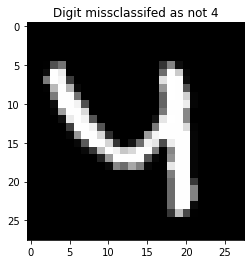

In [235]:
sample = miss_classified[:, 38] * 255
sample = np.reshape(sample, [28,28])
pyplot.imshow(sample, cmap='gray')  # plot the image in "gray" colormap
pyplot.title("Digit missclassifed as not 4")
pyplot.show()